In [1]:
import simpy, random
from queue_simulation import ServiceOperation, SIMULATION_DURATION, SEED

In [2]:
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Initializing OpenUp Queue Simulation')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

random.seed(SEED) # comment out line if not reproducing results
queue_status = []
max_queue_length = []
num_helpseekers = []
num_helpseekers_served = []
num_helpseekers_served_g_regular = []
num_helpseekers_served_g_repeated = []
num_helpseekers_reneged = []
# num_helpseekers_reneged_g_regular = []
# num_helpseekers_reneged_g_repeated = []
num_available_counsellor_processes = []
    
for i in range(1, 1501):
    # create environment
    env = simpy.Environment() 

    # set up service operation and run simulation until  
    S = ServiceOperation(env=env)
    env.run(until=SIMULATION_DURATION)

#     print(f'Iteration #{i} ')
      
    num_helpseekers.append(S.num_helpseekers)
    max_queue_length.append(S.helpseeker_queue_max_length)
    queue_status.extend(S.times_queue_not_empty)
    num_available_counsellor_processes.extend(S.num_available_counsellor_processes)
    num_helpseekers_served.append(S.served)
    num_helpseekers_served_g_regular.append(S.served_g_regular)
    num_helpseekers_served_g_repeated.append(S.served_g_repeated)
    num_helpseekers_reneged.append(S.reneged)
#     num_helpseekers_reneged_g_regular.append(S.reneged_g_regular)
#     num_helpseekers_reneged_g_repeated.append(S.reneged_g_repeated)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initializing OpenUp Queue Simulation
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
sns.set();

In [5]:
num_helpseekers = pd.Series(num_helpseekers, name='number of helpseekers')
num_helpseekers_served = pd.Series(num_helpseekers_served, name='number of helpseekers served')
num_helpseekers_served_g_regular = pd.Series(num_helpseekers_served_g_regular, name='number of users served')
num_helpseekers_served_g_repeated = pd.Series(num_helpseekers_served_g_repeated, name='number of repeated users served')
num_helpseekers_reneged = pd.Series(num_helpseekers_reneged, name='number of helpseekers reneged')
# num_helpseekers_reneged_g_regular = pd.Series(num_helpseekers_reneged_g_regular, name='number of users reneged')
# num_helpseekers_reneged_g_repeated = pd.Series(num_helpseekers_reneged_g_repeated, name='number of repeated users reneged')
# queue_status = pd.Series(queue_status, name='number of instances queue exceeded four helpseekers')
max_queue_length = pd.Series(max_queue_length, name='max queue length')

In [6]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

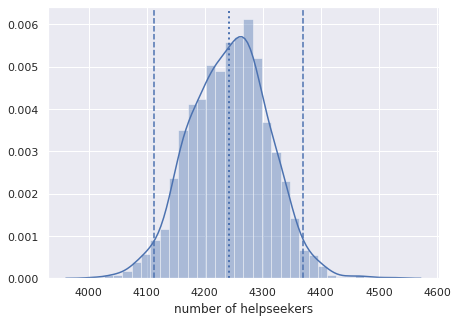

In [9]:
plot_distribution(num_helpseekers, 'num_helpseekers')

In [10]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4112.00000
97.5% percentile: 4369.05000

mean value: 4242.50467


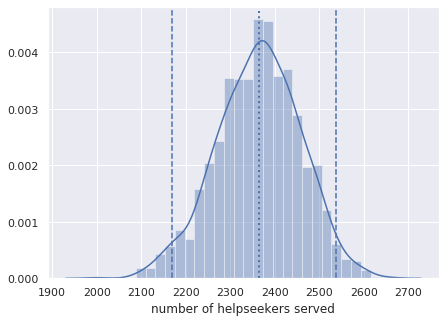

In [11]:
plot_distribution(num_helpseekers_served, 'num_helpseekers_served')

In [12]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2170.00000
97.5% percentile: 2537.10000

mean value: 2363.73533


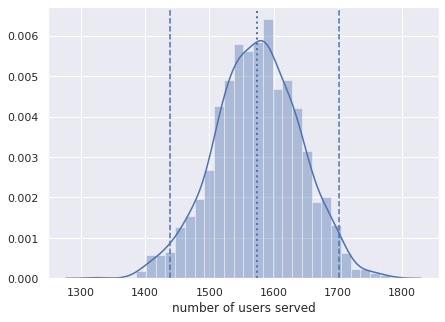

In [13]:
plot_distribution(num_helpseekers_served_g_regular, 'num_helpseekers_served_g_regular')

In [14]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1438.47500
97.5% percentile: 1701.52500

mean value: 1574.55667


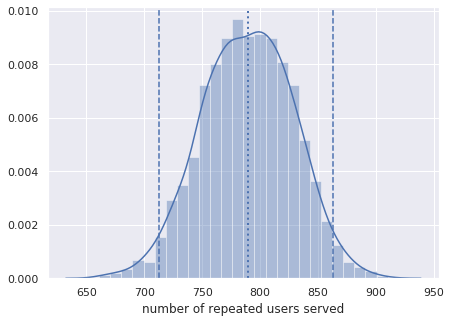

In [15]:
plot_distribution(num_helpseekers_served_g_repeated, 'num_helpseekers_served_g_repeated')

In [16]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 713.00000
97.5% percentile: 862.52500

mean value: 789.17867


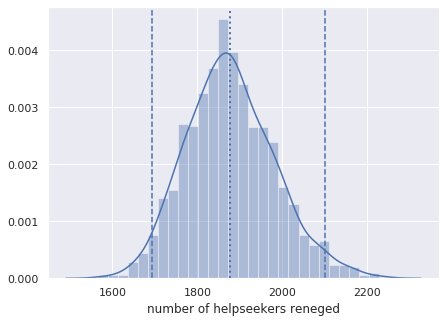

In [17]:
plot_distribution(num_helpseekers_reneged, 'num_helpseekers_reneged')

In [18]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1693.90000
97.5% percentile: 2100.05000

mean value: 1877.99333


In [19]:
# plot_distribution(num_helpseekers_reneged_g_regular, 'num_helpseekers_reneged_g_regular')

NameError: name 'num_helpseekers_reneged_g_regular' is not defined

In [ ]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_helpseekers_reneged_g_regular.sort_values().to_list() )

In [ ]:
plot_distribution(num_helpseekers_reneged_g_repeated, 'num_helpseekers_reneged_g_repeated')

In [ ]:
lower, upper, mean = calculate_confidence_intervals(
    num_helpseekers_reneged_g_repeated.sort_values().to_list() )

In [ ]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [ ]:
queue_status = pd.DataFrame(queue_status, columns=['day_of_week', 'hour', 'queue_length'])

In [ ]:
queue_status['hour'] = queue_status['hour'].str.replace('hour:', '').astype(int)

In [ ]:
queue_status['day_of_week'].replace({
    'weekday:0': 'Sunday',
    'weekday:1': 'Monday',
    'weekday:2': 'Tuesday',
    'weekday:3': 'Wednesday',
    'weekday:4': 'Thursday',
    'weekday:5': 'Friday',
    'weekday:6': 'Saturday'
}, inplace=True)

In [ ]:
queue_status['queue_length'] = queue_status['queue_length'].str.replace('queue_length:', '').astype(int)

In [ ]:
queue_status

In [ ]:
queue_status['total']=1

In [ ]:
totals = queue_status.groupby(
    ['day_of_week', 'hour', 'queue_length']).sum()

In [ ]:
totals = totals.reset_index()

In [ ]:
totals

In [ ]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['day_of_week', 'hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
totals_percent = (((totals.T/totals.T.sum()).T)*100)#.round(2)

totals_percent

In [ ]:
totals_percent

In [ ]:
totals_percent2 = totals_percent.reset_index()

In [ ]:
totals_percent2['day_int'] = totals_percent2['day_of_week'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [ ]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['day_of_week', 'hour']).drop(columns=['day_int'])

In [ ]:
totals_percent2

In [ ]:
totals_percent2['2_or_above'] = 0
for i in totals_percent2.columns[2:]:
    totals_percent2['2_or_above'] += totals_percent2[i]

In [ ]:
totals_percent2.reset_index(inplace=True)

In [ ]:
totals_percent2['new_ind'] = totals_percent2['day_of_week'] + '_'+ totals_percent2['hour'].astype(str)

In [ ]:
totals_percent3 = totals_percent2.set_index('new_ind')[[0, 1, '2_or_above']].copy()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('talk')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 100) )


# sns.heatmap(totals_percent, annot=True, ax=ax, annot_kws={"size": 12}, 
#     cmap=sns.diverging_palette(220, 10, sep=80, n=255)
# );
# fig.suptitle('Queue Length Probabilities by\nthe day of the week and hour\n'
#              '#Social Worker(s) × #sim chats max: 2 × 4,\n'
#              '#Duty Officer(s) × #sim chats max: 1 × 1,\n'
#              '#Volunteer(s) × #sim chats max: 2 × 1',
#     fontsize=24, weight='heavy',
#     fontweight=1000, y=.9)
# plt.subplots_adjust(bottom=0.2)

# # workaround from https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6) )
palette = sns.color_palette("Set3")

fig.suptitle('Conditional Queue Length Probabilities by\n hours of the day of the week',
    fontsize=24, weight='heavy',
    fontweight=1000, y=1.1)

totals_percent3.plot.bar(
    stacked=True,
    ax=ax,
    linewidth=.01,
    color=palette
)
ax.set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
    if x[-2:] == '_0' else ''
    for x in totals_percent3.index])

ax.set_xlabel('Hours of the day')
ax.set_ylabel('Probability (%)')



ax.set_ylim(0,100)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), ncol=3)


In [ ]:
queue_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=queue_status, kind="count",
    height=4, aspect=1);
queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [ ]:
df2 = pd.DataFrame(num_available_counsellor_processes, columns=['time', 'num_counsellor_processes'])

In [ ]:
from queue_simulation import MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR#, MAX_NUM_SIMULTANEOUS_CHATS

In [ ]:
df2['time_int'] = df2['time'].astype(int)

In [ ]:
df2['current_day_minutes'] = df2['time_int'] % MINUTES_PER_DAY

In [ ]:
df2['weekday'] = (df2['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [ ]:
df2['hour'] = (df2['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [ ]:
df2['day_of_week'] = df2['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

# Number of instances when one/no counsellor is available (1500 simulations, seed=728, four or less processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']<=2], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot.png', dpi=300, bbox_inches='tight')

# Number of instances when at least two counsellors are idle (1500 simulations, seed=728, eight or more processes)

In [ ]:
process_plot = sns.catplot(col='day_of_week', y='hour', col_wrap=4,
    col_order=['Sunday',
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday'],
    data=df2[df2['num_counsellor_processes']>=8], kind="count",
    height=4, aspect=1);
process_plot.savefig(f'process_plot_2.png', dpi=300, bbox_inches='tight')